In [199]:
import PDF
from scipy.integrate import quad, dblquad, cumtrapz
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
import timeit
import os



In [178]:
mu_true = 3
sigma_true = 0.3
beta_true= 1
m_true = 1.4
f_true =0.6
lam_true=0.3
mu_b_true =0
sigma_b_true = 2.5

x_min=0
x_max=5
y_min=0 
y_max=10

def integrand(Y, X):
    """Defines the integrand of the double integral of f_tot(x, y)"""
    return PDF.f_tot(X, Y, f=f_true, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true, lam=lam_true, mu_b=mu_b_true, sigma_b=sigma_b_true)


g_s_integral, g_s_error = quad(lambda x: PDF.g_s(x, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true), x_min, x_max)
h_s_integral, h_s_error = quad(lambda x: PDF.h_s(x, lam=lam_true), y_min, y_max)
g_b_integral, g_b_error = quad(PDF.g_b, x_min, x_max) 
h_b_integral, h_b_error = quad(lambda x: PDF.h_b(x, mu_b=mu_b_true, sigma_b=sigma_b_true), y_min, y_max)
f_tot_integral, f_tot_error = dblquad(integrand,x_min, x_max, lambda x: y_min, lambda x: y_max)



# Print the results
print(f"Integral of g_s(x) from {x_min} to {x_max}: {g_s_integral:.6f} (Error estimate: {g_s_error:.6e})")
print(f"Integral of h_s(y) from {y_min} to {y_max}: {h_s_integral:.6f} (Error estimate: {h_s_error:.6e})")
print(f"Integral of g_b(x) from {x_min} to {x_max}: {g_b_integral:.6f} (Error estimate: {g_b_error:.6e})")
print(f"Integral of h_b(y) from {y_min} to {y_max}: {h_b_integral:.6f} (Error estimate: {h_b_error:.6e})")
print(f"Integral of f_tot(x, y) from {x_min} to {x_max} and {y_min} to {y_max}: {f_tot_integral:.6f} (Error estimate: {f_tot_error:.6e})")

Integral of g_s(x) from 0 to 5: 1.000000 (Error estimate: 7.289797e-09)
Integral of h_s(y) from 0 to 10: 1.000000 (Error estimate: 1.110223e-14)
Integral of g_b(x) from 0 to 5: 1.000000 (Error estimate: 1.110223e-14)
Integral of h_b(y) from 0 to 10: 1.000000 (Error estimate: 4.839198e-12)
Integral of f_tot(x, y) from 0 to 5 and 0 to 10: 1.000000 (Error estimate: 4.373879e-09)


## Part C

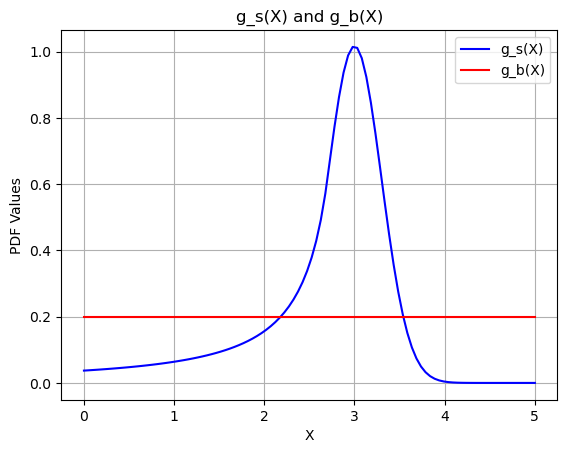

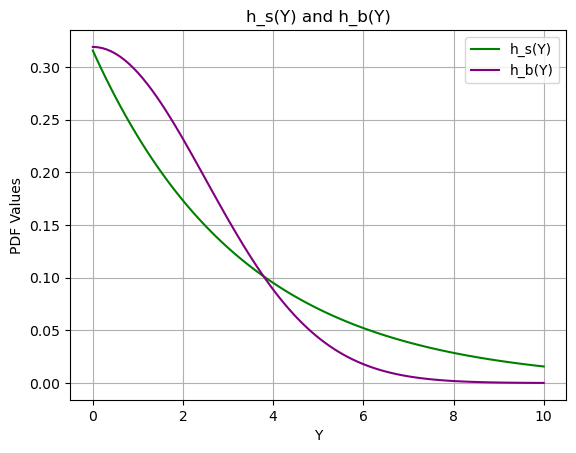

In [179]:
X=np.linspace(0,5,100)
Y=np.linspace(0,10,100)
plt.figure(1)  # First figure
plt.plot(X, PDF.g_s(X, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true), label="g_s(X)", color='blue')
plt.plot(X, PDF.g_b(X), label="g_b(X)", color='red')
plt.title("g_s(X) and g_b(X)")
plt.xlabel("X")
plt.ylabel("PDF Values")
plt.legend()
plt.grid(True)

plt.savefig('g_s_and_g_b_plot.png', dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()
plt.close()

# Create the second figure for h_s(Y) and h_b(Y)
plt.figure(2)  # Second figure
plt.plot(Y, PDF.h_s(Y, lam=lam_true), label="h_s(Y)", color='green')
plt.plot(Y, PDF.h_b(Y, mu_b=mu_b_true, sigma_b=sigma_b_true), label="h_b(Y)", color='purple')
plt.title("h_s(Y) and h_b(Y)")
plt.xlabel("Y")
plt.ylabel("PDF Values")
plt.legend()
plt.grid(True)
plt.savefig('h_s_and_h_b_plot.png', dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()
plt.close()

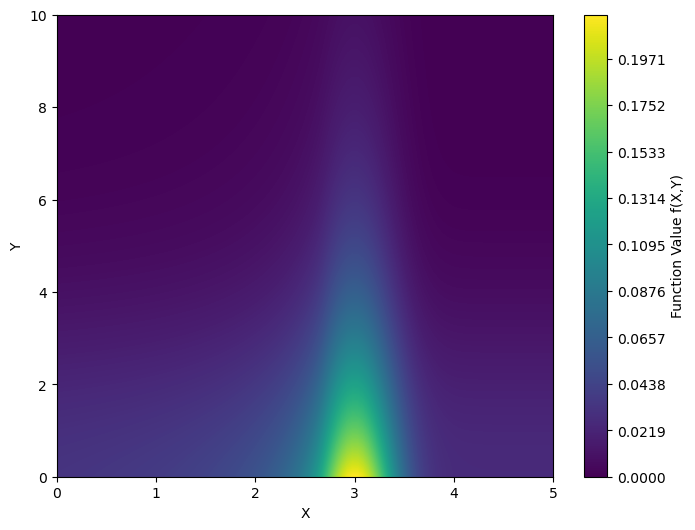

In [180]:
X=np.linspace(0,5,100)
Y=np.linspace(0,10,100)
X, Y = np.meshgrid(X, Y)
Z = PDF.f_tot(X, Y, f=f_true, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true, lam=lam_true, mu_b=mu_b_true, sigma_b=sigma_b_true)


plt.figure(figsize=(8, 6))

# Filled contour plot
contour_filled = plt.contourf(X, Y, Z, levels=800, cmap='viridis')

# Add a colorbar to the filled contour plot
plt.colorbar(contour_filled, label='Function Value f(X,Y)')



plt.clabel(CS, fmt='%2.3f', colors='b', fontsize=14)
# Add labels and title

plt.xlabel("X")
plt.ylabel("Y")
plt.savefig('f_tot_plot.png', dpi=300, bbox_inches='tight')  # Save as PNG
# Display the plot
plt.show()


## Part d

In [194]:
max_value = np.max(Z)
def faster_event_generation(N):
    """
    This function generated N events using the acceptance-rejection method, 
    batches of N/2 events are generated each loop to speed up the process.
    """
    accepted_points = []
    np.random.seed(10)
    while len(accepted_points)<N:
        x_batch = np.random.uniform(0, 5, int(N/2))
        y_batch = np.random.uniform(0, 10, int(N/2))
        y_guess = np.random.uniform(0, max_value, int(N/2))
        y_val = PDF.f_tot(x_batch, y_batch, f=f_true, beta=beta_true, m=m_true, 
                    mu=mu_true, sigma=sigma_true, lam=lam_true, mu_b=mu_b_true,
                    sigma_b=sigma_b_true)
        accepted_indices = y_guess <= y_val
        # Add accepted points to the list
        accepted_points.extend(zip(x_batch[accepted_indices], y_batch[accepted_indices]))
            
            
    accepted_points = np.array(accepted_points[:N])
    
    return accepted_points


    

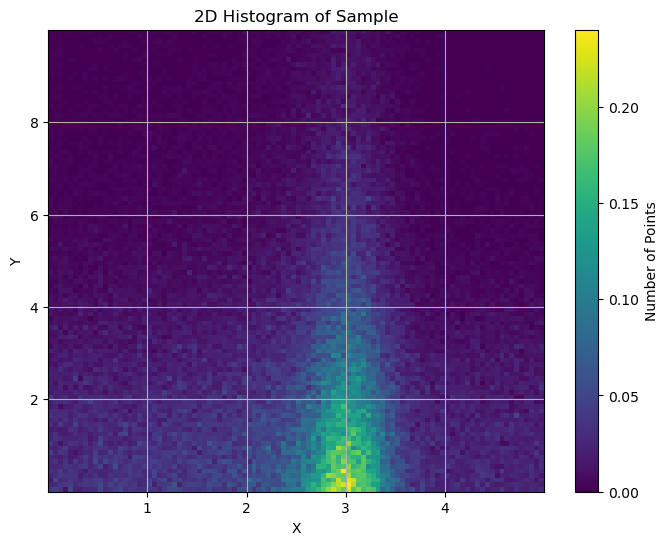

In [195]:
sample = faster_event_generation(100000)   
x = sample[:, 0]
y = sample[:, 1]
plt.figure(figsize=(8, 6))
plt.hist2d(x, y, bins=100, cmap='viridis',density=True)

# Add a colorbar to show the number of points in each bin
plt.colorbar(label='Number of Points')

plt.title("2D Histogram of Sample")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.savefig('sample_2D.png', dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()

In [196]:
def density(data,N,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    X,Y =data
    return N, N*PDF.f_tot(X,Y,f,beta,m,mu,sigma,lam,mu_b,sigma_b)

nll = ExtendedUnbinnedNLL(sample.T, density)

mi = Minuit(nll , N=100000, f=0.6 ,beta=1 ,m=1.4 ,mu=3 ,sigma=0.3 ,lam=0.3 ,mu_b=0.0 ,sigma_b=2.5)

mi.migrad()

mi.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.461e+06                 │              Nfcn = 268              │
│ EDM = 0.00107 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N       │ 100.00e3  │  0.32e3   │            │            │         │         │       │
│ 1 │ f       │   0.600   │   0.004   │            │            │         │         │       │
│ 2 │ beta    │   0.988   │   0.022   │            │            │         │         │       │
│ 3 │ m       │   1.44    │   0.06    │            │            │         │         │       │
│ 4 │ mu      │  3.0017   │  0.0026   │            │            │         │         │       │
│ 5 │ sigma   │  0.2999   │  0.0025   │            │            │         │         │       │
│ 6 │ lam     │  0.3009   │  0.0021   │            │            │         │         │       │
│ 7 │ mu_b    │   0.07    │   0.08    │            │            │         │         │       │
│ 8 │ sigma_b │   2.47    │   0.04    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│         │         N         f      beta         m        mu     sigma       lam      mu_b   sigma_b │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│       N │     1e+05 -3.54e-08 -1.07e-07  8.29e-07 -1.18e-08 -2.73e-09  -4.1e-08 -1.03e-06  3.82e-07 │
│       f │ -3.54e-08  1.27e-05   7.4e-06 -8.51e-05 -2.33e-07   2.6e-06  1.91e-06  4.92e-05 -2.88e-05 │
│    beta │ -1.07e-07   7.4e-06  0.000486  -0.00121 -3.08e-05  2.55e-05  5.07e-07  6.89e-05 -4.54e-05 │
│       m │  8.29e-07 -8.51e-05  -0.00121   0.00411  5.75e-05 -5.38e-05 -1.25e-05 -0.000532  0.000331 │
│      mu │ -1.18e-08 -2.33e-07 -3.08e-05  5.75e-05  6.92e-06 -3.63e-06 -1.04e-08 -2.82e-06  1.79e-06 │
│   sigma │ -2.73e-09   2.6e-06  2.55e-05 -5.38e-05 -3.63e-06  6.08e-06  3.86e-07  1.61e-05 -9.98e-06 │
│     lam │  -4.1e-08  1.91e-06  5.07e-07 -1.25e-05 -1.04e-08  3.86e-07  4.26e-06  1.03e-05  3.83e-06 │
│    mu_b │ -1.03e-06  4.92e-05  6.89e-05 -0.000532 -2.82e-06  1.61e-05  1.03e-05   0.00573   -0.0025 │
│ sigma_b │  3.82e-07 -2.88e-05 -4.54e-05  0.000331  1.79e-06 -9.98e-06  3.83e-06   -0.0025   0.00128 │
└─────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

<ValueView N=100000.10550859863 f=0.599696877927897 beta=0.9880766909339282 m=1.4377852412440766 mu=3.001653031833855 sigma=0.29990353668241865 lam=0.3009305674885464 mu_b=0.06836219301025619 sigma_b=2.4739106063352523>


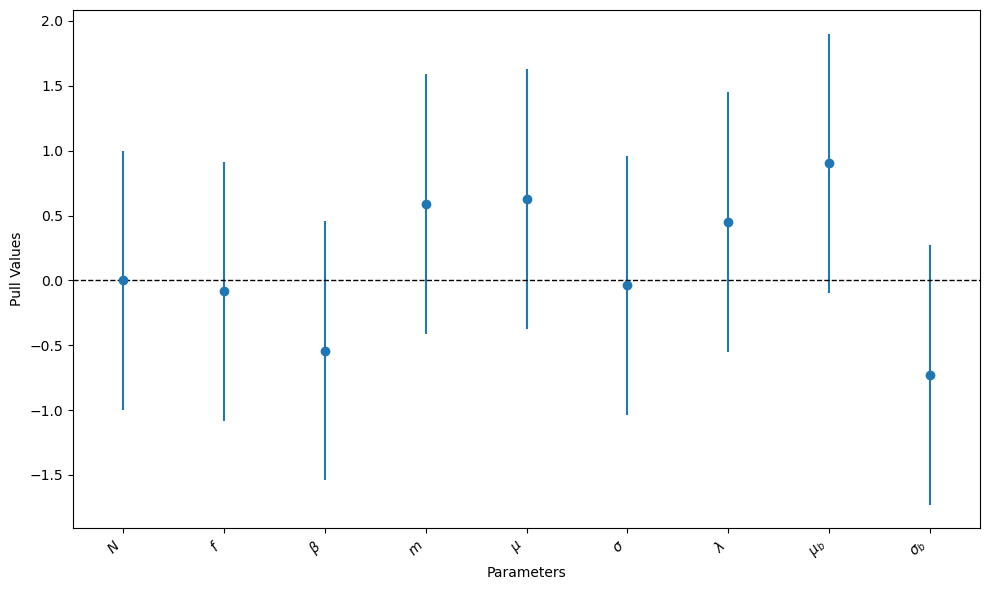

In [197]:
orig_fit= mi.values
orig_errors= mi.errors  
true_values = {
    '$N$': 100000,
    '$f$': 0.6,
    '$ beta $': 1,
    '$m$': 1.4,
    '$\mu$': 3,
    '$\sigma$': 0.3,
    '$\lambda$': 0.3,
    '$\mu_b$': 0.0,
    '$\sigma_b$': 2.5
}


print(orig_fit )
pull=[]

for i in range(len(orig_fit)):
    residual = (orig_fit[i]-np.array(list(true_values.values()))[i])
    pull.append(residual/orig_errors[i])

fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(range(len(pull)), pull, yerr=1, fmt='o', label='Fit')

ax.axhline(0, color='black', lw=1, ls='--')


#ax.fill_between([-0.5,len(pull)], -1, 1, color='green', alpha=0.2, label='1$\sigma$')

ax.set_xticks(range(len(true_values)))  # Use the number of parameters
ax.set_xticklabels([r'$N$', r'$f$', r'$\beta$', r'$m$', r'$\mu$', r'$\sigma$', r'$\lambda$', r'$\mu_b$', r'$\sigma_b$'], rotation=45, ha='right')

ax.set_xlabel('Parameters')
ax.set_ylabel('Pull Values')

ax.set_xlim(-0.5, len(pull) - 0.5) 
# Show the plot
plt.tight_layout()
plt.savefig('pull_plot.png', dpi=300, bbox_inches='tight')  # Save as PNG

In [185]:


def run_faster_event_generation():
    faster_event_generation(100000)

def run_normal_dist():
    np.random.normal(size=100000)

def run_fit():
    mi.migrad()

time_norm = timeit.timeit(run_normal_dist, number=100)
average_time_norm = time_norm / 100

time_gen = timeit.timeit(run_faster_event_generation, number=100)
average_time_gen = time_gen / 100
average_time_gen_rel=average_time_gen/average_time_norm

time_fit = timeit.timeit(run_fit, number=100)
average_time_fit = time_fit / 100
average_time_fit_rel=average_time_fit/average_time_norm



print(f"Average time for 100 runs of normal dist: {average_time_norm:.4f} seconds")
print(f"Average relative time for 100 runs of event generation: {average_time_gen_rel:.4f} ")
print(f"Average relative time for 100 runs of fitting: {average_time_fit_rel:.4f}")

Average time for 100 runs of normal dist: 0.0011 seconds
Average relative time for 100 runs of event generation: 114.4568 
Average relative time for 100 runs of fitting: 246.6156


## Part e

In [213]:
import ast  

def extract_values_and_errors(folder_name):
    extracted_data = []
    
    # Check if the folder exists
    if not os.path.exists(folder_name):
        print(f"Folder '{folder_name}' does not exist.")
        return extracted_data
    
    # Iterate over all files in the folder
    for filename in os.listdir(folder_name):
        if filename.endswith("_values_and_errors.txt"):
            file_path = os.path.join(folder_name, filename)
            with open(file_path, 'r') as file:
                # Read the lines in the file
                lines = file.readlines()

                sample_size = int(lines[0].split(":")[1].strip())
                
                # Extract values (lines between "Values:" and "Errors:")
                values_start_index = lines.index("Values:\n") + 1
                values_end_index = lines.index("Errors:\n")
                values = ast.literal_eval(''.join(lines[values_start_index:values_end_index]).strip())
                
                # Extract errors (lines after "Errors:")
                errors_str = ''.join(lines[values_end_index + 1:]).strip()
                errors_str = errors_str.replace('nan', '0.00000')
                errors = ast.literal_eval(errors_str)
                    
                #Store the extracted data
                extracted_data.append({
                    'sample_size': sample_size,
                    'values': values,
                    'errors': errors
                })

    for data in extracted_data:
        sample_size = data['sample_size']
        values_length = len(data['values'])
        errors_length = len(data['errors'])
        print(f"Sample size: {sample_size} | Length of values: {values_length} | Length of errors: {errors_length}")
    true_values_filename = os.path.join(folder_name, 'true_values.txt')      
    true_values = {}
    with open(true_values_filename, 'r') as file:
        lines = file.readlines()
        for line in lines:
            # Remove any extra whitespace
            line = line.strip()
            # Split the line into key and value
            if ':' in line:
                key, value = line.split(":", 1)
                # Remove spaces from key and value, convert value to float
                key = key.strip()
                value = value.strip()
                true_values[key] = float(value)
            

    return extracted_data, true_values

def read_lambda_vals(extracted_data,true_values):
    element_values={}
    element_errors={}
    for data in extracted_data:
        sample_size = data['sample_size']
        values = data['values']
        errors = data['errors']

        sample_values = []
        sample_errors = []

        for i in range(len(values)):
            sample_values.append(values[i][6])
            sample_errors.append(errors[i][6])

        element_values[f'sample_{sample_size}_lam_values'] = sample_values
        element_errors[f'sample_{sample_size}_lam_errs'] = sample_errors

    true_lam_val = true_values.get('lam', None)

    return element_values, element_errors, true_lam_val


extracted_data, true_values = extract_values_and_errors("Parametric_Bootstrapping_Data")
print('true_values:', true_values)

lam_values, lam_errors, true_lam = read_lambda_vals(extracted_data, true_values)
print('true lambda:', true_lam)

sample_500_lam_values = lam_values.get('sample_500_lam_values', None)
sample_500_lam_errors = lam_errors.get('sample_500_lam_errs', None)

sample_1000_lam_values = lam_values.get('sample_1000_lam_values', None)
sample_1000_lam_errors = lam_errors.get('sample_1000_lam_errs', None)

sample_2500_lam_values = lam_values.get('sample_2500_lam_values', None)
sample_2500_lam_errors = lam_errors.get('sample_2500_lam_errs', None)

sample_5000_lam_values = lam_values.get('sample_5000_lam_values', None)
sample_5000_lam_errors = lam_errors.get('sample_5000_lam_errs', None)

sample_10000_lam_values = lam_values.get('sample_10000_lam_values', None)
sample_10000_lam_errors = lam_errors.get('sample_10000_lam_errs', None)



Sample size: 1000 | Length of values: 250 | Length of errors: 250
Sample size: 5000 | Length of values: 250 | Length of errors: 250
Sample size: 500 | Length of values: 250 | Length of errors: 250
Sample size: 2500 | Length of values: 250 | Length of errors: 250
Sample size: 10000 | Length of values: 250 | Length of errors: 250
true_values: {'N': 100000.10895733528, 'f': 0.5961361638013981, 'beta': 0.9646503836310345, 'm': 1.479439970264601, 'mu': 3.002638427507654, 'sigma': 0.2992357808277463, 'lam': 0.29585349437316233, 'mu_b': -0.006084193641731449, 'sigma_b': 2.4630290286509626}
true lambda: 0.29585349437316233


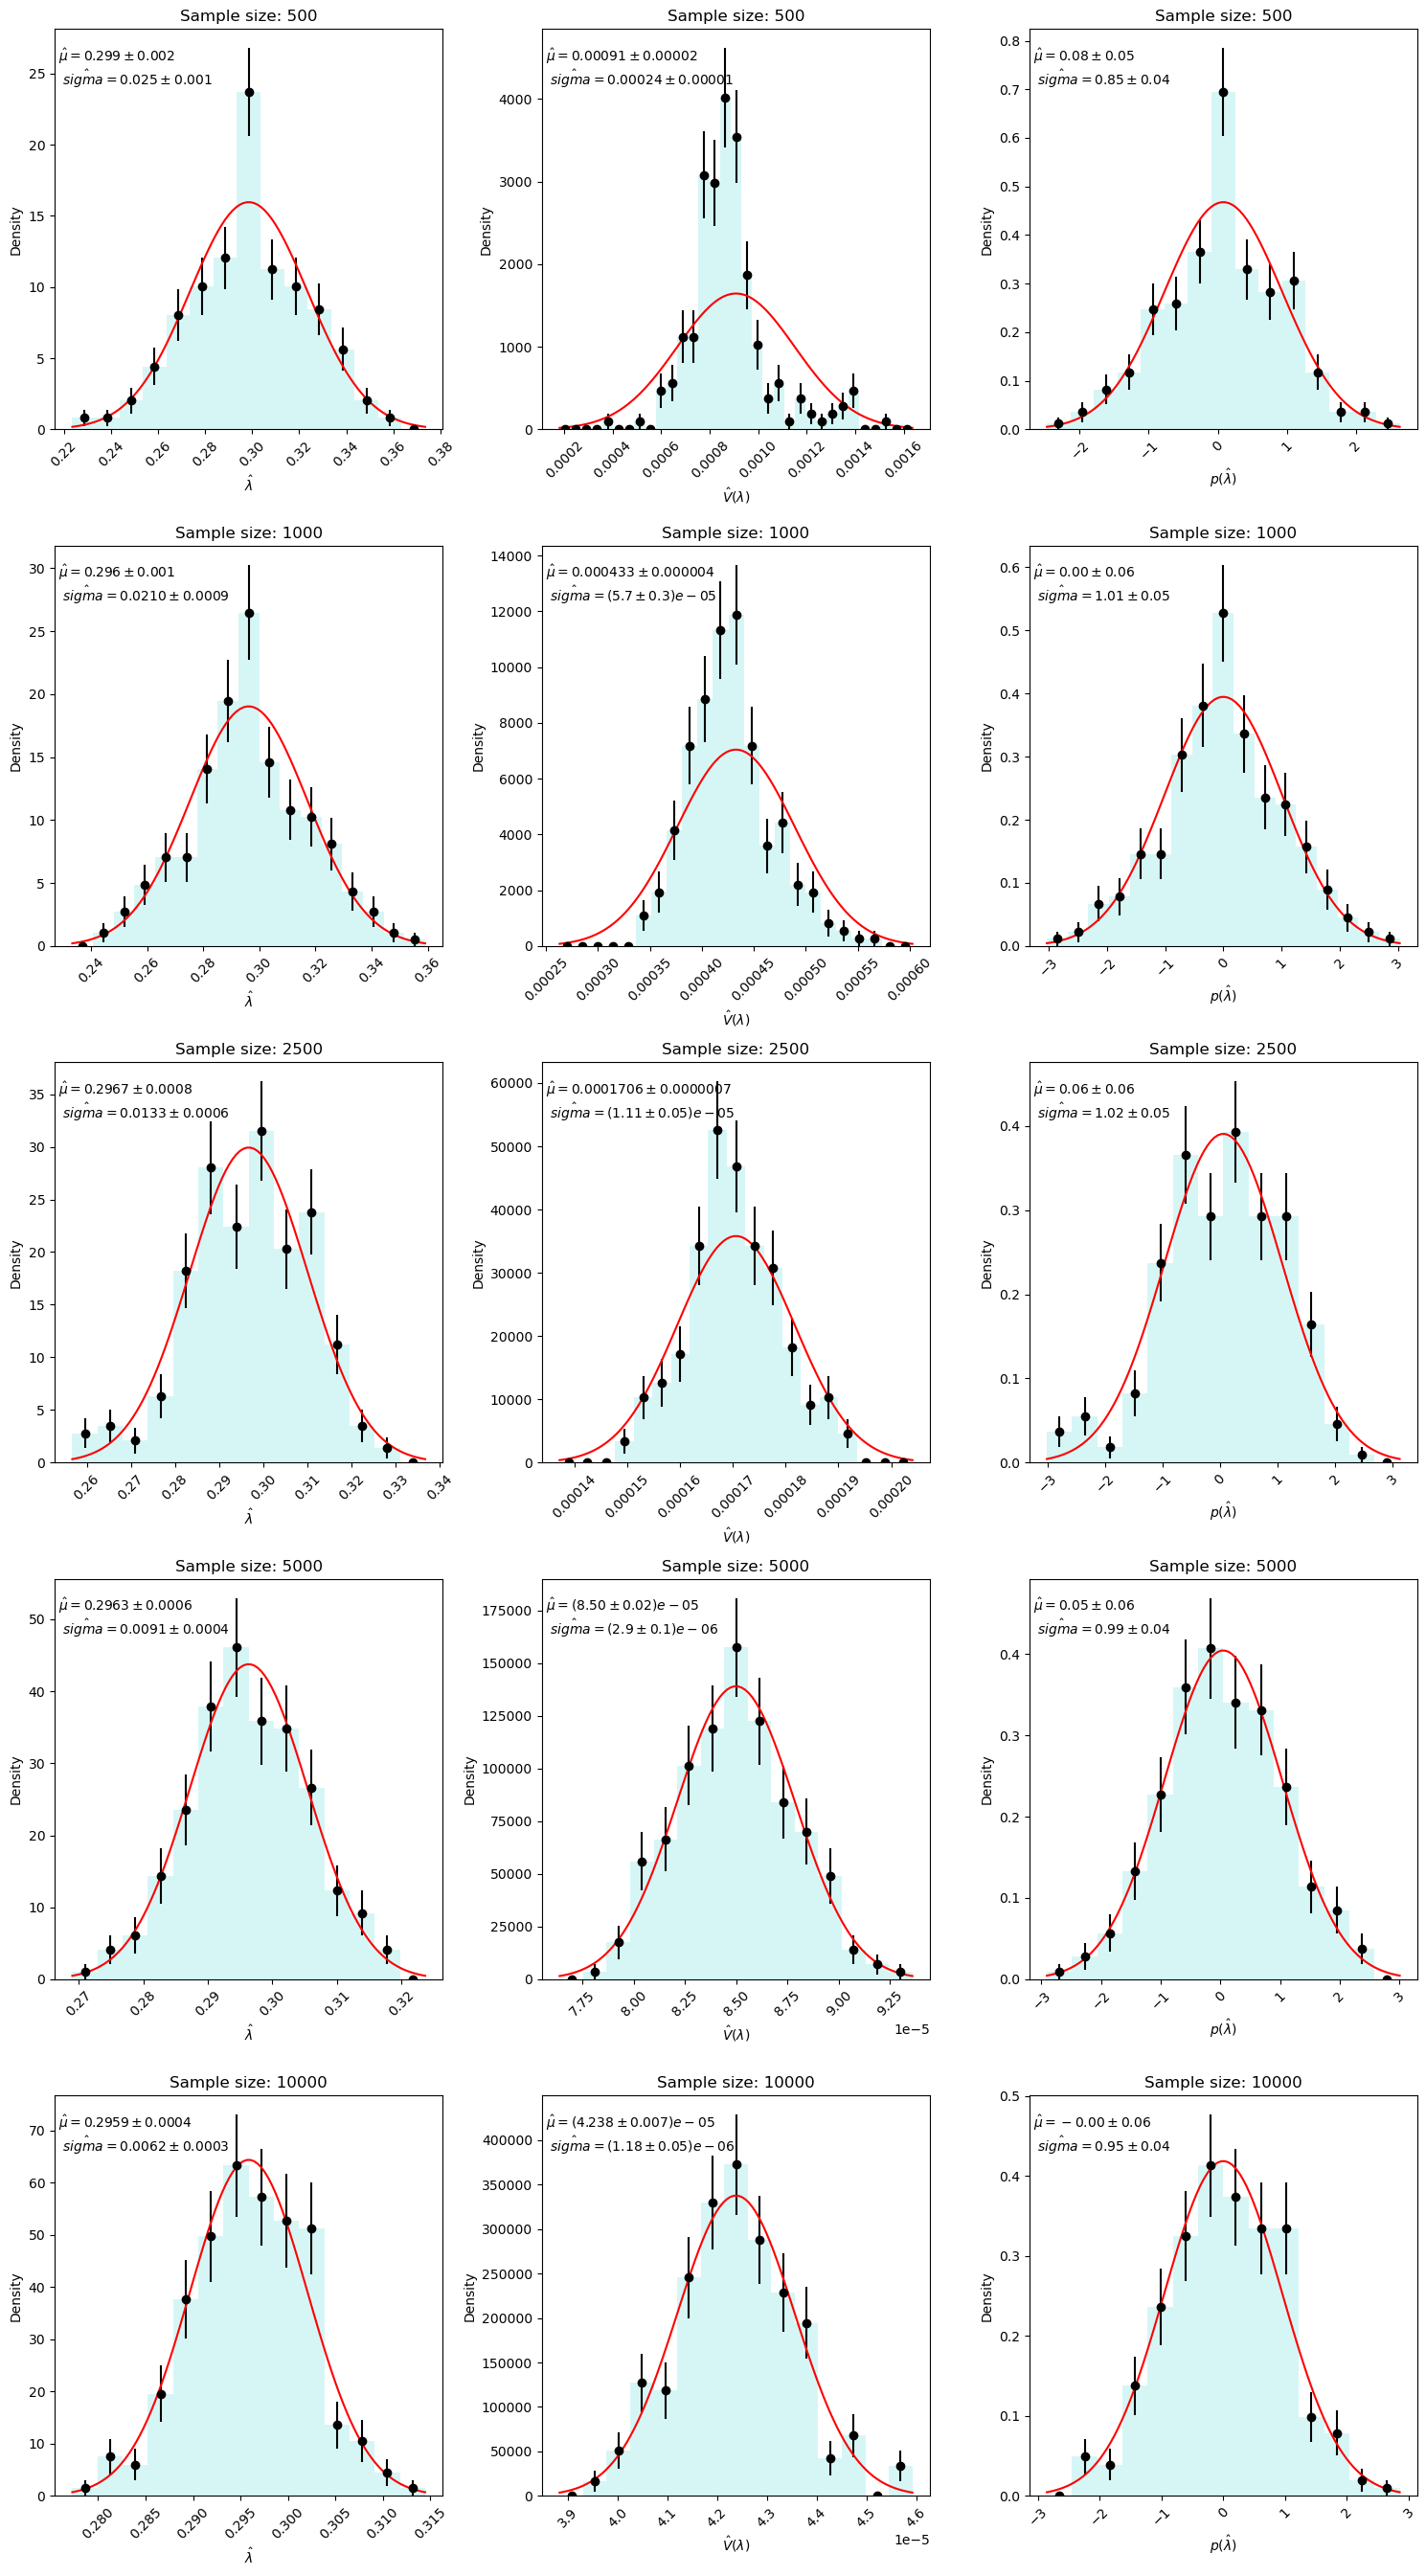

In [233]:
import uncertainties as uncert
from matplotlib.ticker import ScalarFormatter
Names = ['N', 'f', 'beta', 'm', 'mu', 'sigma', 'lambda', 'mu_b', 'sigma_b']


def plot(xvals , ax=None):
    ax = ax or plt.gca()
    # compute mean , sdev and their errors of distribution
    m = np.mean(xvals)
    s = np.std(xvals , ddof=1)
    me = s/len(xvals)**0.5
    se = s/(2*len(xvals)-1)**0.5
    # make a density histogram
    nh, xe = np.histogram( xvals , range =(m-3*s,m+3*s), bins='auto', density=True )
    # draw the density histogram
    ax.hist( xvals , bins=xe, density=True , alpha=0.5,color='paleturquoise' )
    # also draw error bars on points
    N = np.sum(nh)/len(xvals)
    cx = 0.5*(xe[1:]+xe[:-1])
    ax.errorbar( cx, nh, N*(nh/N)**0.5, fmt='ko')
    # draw the normal distribution with the mean and sigma
    x = np.linspace(xe[0],xe[-1],100)
    ax.plot(x, norm.pdf(x,m,s), 'r-')
    # plot the results (use uncertainties package for nice formatting)
    um = uncert.ufloat( m, me )
    us = uncert.ufloat( s, se )
    mstr = f"{um:.1u}".replace("+/-","\pm")
    sstr = f"{us:.1u}".replace("+/-","\pm")
    ax.text(0.01,0.92, f"$\hat{{\mu}} = {mstr}$", transform=ax.transAxes)   
    ax.text(0.01,0.86, f"$\hat{{\ sigma}} = {sstr}$", transform=ax.transAxes)
    ax.set_ylabel('Density')
    plt.tight_layout()


sample_sizes = [500, 1000, 2500, 5000, 10000]
sample_lam_values = {
    500: sample_500_lam_values,    
    1000: sample_1000_lam_values,  
    2500: sample_2500_lam_values,  
    5000: sample_5000_lam_values, 
    10000: sample_10000_lam_values 
}

sample_lam_errors = {
    500: sample_500_lam_errors,    
    1000: sample_1000_lam_errors, 
    2500: sample_2500_lam_errors,  
    5000: sample_5000_lam_errors,  
    10000: sample_10000_lam_errors 
}


fig, axes = plt.subplots(5, 3, figsize=(15, 27))  
for i, sample_size in enumerate(sample_sizes):
    # Get the lam values and errors for this sample size
    values = np.array(sample_lam_values[sample_size])
    errors = np.array(sample_lam_errors[sample_size])
    
    # Calculate the pulls (residuals normalized by errors)
    pulls = (values - true_lam) / errors
    
    name = '\lambda'
    estname = f"\hat {{{ name.split('_ ')[0]}}}"
    if len(name.split('_'))>1: estname += '_'+name.split('_')[1]
        
    ax = axes[i,0]
    plot( values, ax )
    ax.set_xlabel( f"${estname}$" )

    ax = axes[i,1]
    plot( errors**2, ax )
    ax.set_xlabel( f"$\hat{{V}}({ name})$" )

    ax = axes[i,2]
    plot( pulls, ax )
    ax.set_xlabel( f"$p({ estname })$" )

    axes[i, 0].set_title(f"Sample size: {sample_size}")
    axes[i, 1].set_title(f"Sample size: {sample_size}")
    axes[i, 2].set_title(f"Sample size: {sample_size}")

for ax_row in axes:
    for ax in ax_row:
        for label in ax.get_xticklabels():
            label.set_rotation(45)

plt.tight_layout()




[0.05393938 0.06389496 0.06460808 0.06237653 0.06023404]


/var/folders/27/607d42hs7jz87b8yg71lpk5r0000gn/T/ipykernel_39602/3675675608.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([500,10000],[1,1], 'k--', c='b')
/var/folders/27/607d42hs7jz87b8yg71lpk5r0000gn/T/ipykernel_39602/3675675608.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([500,10000],[-1,-1], 'k--', c='b')


<ErrorbarContainer object of 3 artists>

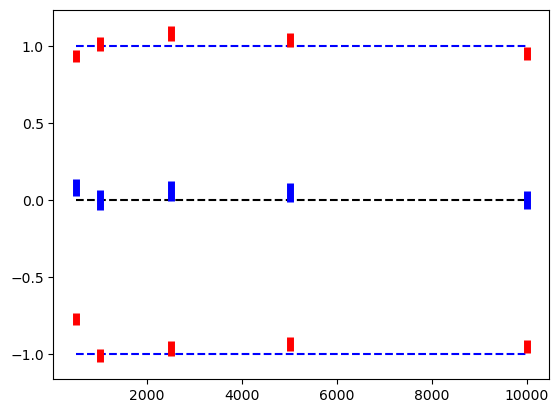

In [228]:
pull_data=[]

for i, sample_size in enumerate(sample_sizes):
    values = np.array(sample_lam_values[sample_size])
    errors = np.array(sample_lam_errors[sample_size])
    
    # Calculate the pulls (residuals normalized by errors)
    pulls = (values - true_lam) / errors


    m = np.mean(pulls)
    s = np.std(pulls , ddof=1)
    me = s/len(pulls)**0.5
    se = s/(2*len(pulls)-1)**0.5

    pull_data.append([m, me, s, se])


sample_sizes = [500, 1000, 2500, 5000, 10000]
pull_data = np.array(pull_data)
print(pull_data[:,1])

plt.plot([500,10000],[0,0], 'k--')
plt.plot([500,10000],[1,1], 'k--', c='b')
plt.plot([500,10000],[-1,-1], 'k--', c='b')
plt.errorbar(sample_sizes, pull_data[:, 0], yerr=pull_data[:, 1], fmt='o', color='blue', label='Mean ± Error', capsize=0,markersize=2, elinewidth=5)


plt.errorbar(sample_sizes, pull_data[:, 0]+pull_data[:, 2], yerr=pull_data[:, 3], fmt='o', color='red', capsize=0,markersize=2, elinewidth=5)
plt.errorbar(sample_sizes, pull_data[:, 0]-pull_data[:, 2], yerr=pull_data[:, 3], fmt='o', color='red', capsize=0,markersize=2, elinewidth=5)
